オリジナルの作成: 

<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>SageでTheanoの畳み込みニューラルネットを体験する</h1>
	<h2>参考サイト</h2>
	<p>	
		ここでは、
		 <a href="http://aidiary.hatenablog.com/">人工知能に関する断創録</a>
		 のTheanoに関連する記事をSageのノートブックで実装し、Thenoの修得を試みます。	
	</p>
	<p>
		今回は、TheanoのTutorialから畳み込みニューラルネット（CNN）を使った手書き数字認識を以下のページを参考にSageのノートブックで試してみます。
		前半は、人工知能に関する断創録から参照されている「StatsFragments」さんのページを参考に畳み込みとMaxPoolingをSageで動かしてみました（ほぼ引用ですみません）。
		<ul>
			<li>
				<a href="http://sinhrks.hatenablog.com/entry/2014/12/07/203048">Theano で Deep Learning ＜3＞ : 畳み込みニューラルネットワーク</a>
			</li>
			<li>
				<a href="http://aidiary.hatenablog.com/entry/20150626/1435329581">Theanoによる畳み込みニューラルネットワークの実装 (1)</a>
			</li>
		</ul>		
	</p>
</html>

<html>
	<h2>前準備</h2>
	<h3>処理系をSageからPythonに変更</h3>
	<p>
		SageでTheanoのtutorialのCNNを実行すると、DimShuffleでエラーになるため、今回もPythonを使用します。	
	</p>
	<p>
		そこで、ノートブックの処理系をSageからPythonに切り替えます。上部の左から4つめのプルダウンメニューから
		「python」を選択してください。
	</p>
	<p>
		<img src="images/theano_setup.png"/>
	</p>
</html>

<html>
	<h3>必要なライブラリのimport</h3>
	<p>
		最初に、theanoを使うのに必要なライブラリをインポートします。
	</p>
</html>

In [1]:
# 必要なライブラリのインポート
import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit
import time
import urllib

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import theano
import theano.tensor as T
from theano.tensor.nnet import conv
# 変更され、パッケージが移動
# from theano.tensor.signal import downsample
from theano.tensor.signal import pool

# これまで確認したlogistic_sgd.pyのLogisticRegression, mlpのHiddenLayerをインポートする
from logistic_sgd import LogisticRegression, load_data
from mlp import HiddenLayer

<html>
	<h2>畳み込みニューラルネットワークの構成</h2>
	<p>
		「Theanoによる畳み込みニューラルネットワークの実装 (1)」から
		ニューラルネットワーク（CNN）の構成図を引用します。
	</p>
	<p>
		<img width="60%" height="60%" src="http://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20150626/20150626203849.png"/>
	</p>
	<p>
		最初に畳み込み（convolutionの矢印部）とプーリング（maxpoolingの矢印部）を持つLeNetConvPoolLayerが2層あり、
		その後に多層パーセプトロン（HiddenLayer）と最後のロジスティック（LogisticRegression）から構成されています。
	</p>
	<p>
		前半の畳み込みでは画像の特徴を際立たせるためのフィルタリングを行い、Max Poolingでは画像のずれを吸収し、
		疎な結合を構成しています。
	</p>
</html>

<html>
	<h3>畳み込み演算</h3>
	<p>
		<a href="http://sinhrks.hatenablog.com/entry/2014/12/07/203048">Theano で Deep Learning ＜3＞ : 畳み込みニューラルネットワーク</a>
		の例題をSageで動かしながら、畳み込み演算の効果をみてみましょう。
	</p>
	<p>
		Theanoでは、畳み込みの処理がパッケージtheano.tensor.nnet.convのconv2dで提供されています。
	</p>
	<p>
		conv2dへの入力テンソルは、以下の様な次元を持ちます。
		<ul>
			<li>Minibatchのサイズ: 以下の例では入力が1個なので1としています</li>
			<li>入力の特徴マップ数: 例ではRGBの3つを特徴マップとしているので、3としています</li>
			<li>W: 重みテンソル、次元は（出力特徴マップ数、入力特徴マップ数、フィルタの縦幅、フィルタの横幅）</li>
			<li>b: バイアスベクトル、長さは出力の特徴マップ数</li>
		</ul>
	</p>
	<p>
		入力テンソルinputを4次元のテンソルとして定義します。
	</p>
</html>

In [2]:
rng = np.random.RandomState(23455)
# 入力画像を受けとるシンボルを作成
input = T.tensor4(name='input')

<html>
	<p>
		重みテンソルWの次元は、（2, 3, 9, 9）で、フィルタは9x9で、2x3（出力の特徴マップ数x入力の特徴マップ数）=6種類のフィルタが使われます。
	</p>
	<p>
		以下の例では、重みの値は一様乱数を使って生成した意味のないものです。実際にはこのWが学習によって画像の特徴をより抽出できる形になります。
	</p>
</html>

In [3]:
# 重みテンソル 
# W の次元を指定 ( 出力の特徴マップ数, 入力の特徴マップ数, 畳み込み(フィルタ)の縦幅, 畳み込み(フィルタ)の横幅)
w_shp = (2, 3, 9, 9)

# 発生させる一様乱数の範囲を指定
w_bound = np.sqrt(3 * 9 * 9)
-1.0 / w_bound, 1.0 / w_bound

(-0.064150029909958411, 0.064150029909958411)

<html>
	<p>
		バイアスベクトルは、出力の特徴マップ数の長さを持ち、フィルタリングの後に各画像に加えられます。
	</p>
	<p>
		そのため、4次元のテンソルと足し合わせられるようにdimshuffleで次元を調整します。
		ここでは、conv_outの２つ目の次元と合うようにします。
	</p>
</html>

In [4]:
# 重みテンソルを初期化
W = theano.shared( np.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=input.dtype), name ='W')

# バイアスベクトルを初期化
b_shp = (2,)
b = theano.shared(np.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=input.dtype), name ='b')
b.get_value()

array([-0.3943425 ,  0.16818965])

In [5]:
b.dimshuffle('x', 0, 'x', 'x').eval()

array([[[[-0.3943425 ]],

        [[ 0.16818965]]]])

In [6]:
# 畳み込み とバイアスの足し合わせの定義
conv_out = conv.conv2d(input, W)
output = T.nnet.sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))
f = theano.function([input], output)

<html>
	<h3>畳み込みの画像</h3>
	<p>
		通常の画像をどのようにしてTheanoで解析可能な形式にするのか、
		<a href="http://sinhrks.hatenablog.com/entry/2014/12/07/203048">Theano で Deep Learning ＜3＞ : 畳み込みニューラルネットワーク</a>
		の例がとても分かりやすく参考になりました。
	</p>
	<p>
		入力画像は、縦130px * 横120pxのRGBのJPEGファイルです。
	</p>
	<p>
		これをswapaxesを使ってTheanoの入力にあった形式に変換していきます。
	</p>
</html>

In [7]:
# 画像の読み込み
from scipy.misc import imread

# 読み込むファイル名を指定
# PILでjpegのdecodeができないため、pngに変換して使用
# img = imread("images/01.jpg")
img = imread("images/01.png")
img = img / 256.
# 元画像の次元 (縦幅, 横幅, RGB)
img.shape

(130, 120, 3)

In [8]:
# 1軸目と3軸目を入替 (RGB, 横幅, 縦幅)
img.swapaxes(0, 2).shape

(3, 120, 130)

In [9]:
# 2軸目と3軸目を入替 (RGB, 縦幅, 横幅)
img.swapaxes(0, 2).swapaxes(1, 2).shape

(3, 130, 120)

In [10]:
# 1軸目にダミーの軸を追加 (dummy, RGB, 縦幅, 横幅)
img.swapaxes(0, 2).swapaxes(1, 2).reshape(1, 3, img.shape[0], img.shape[1]).shape

(1, 3, 130, 120)

In [11]:
img_ = img.swapaxes(0, 2).swapaxes(1, 2).reshape(1, 3, img.shape[0], img.shape[1])

<html>
	<h3>サンプル画像へのたたき込み</h3>
	<p>
		サンプル画像のRGBのそれぞれの画像にフィルタを使って畳み込みを施すと以下の様になります。
	</p>
	<p>
		フィルタによる畳み込みで2つの特徴マップ（画像）は、異なる表情を示します。
		これがフィルタによる特徴抽出の効果です。
	</p>
</html>

In [12]:
# 係数テンソル + バイアスベクトルを適用
filtered_img = f(img_)
filtered_img.shape

(1, 2, 122, 112)

オリジナルの画像
<img src='images/01.png'/>

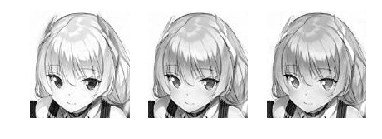

In [13]:
# RGBの画像
plt.figure()
for index in range(3):
    plt.subplot(1, 3, index + 1)
    plt.axis('off')
    plt.imshow(img_[0][index], cmap=plt.cm.gray, interpolation='nearest')

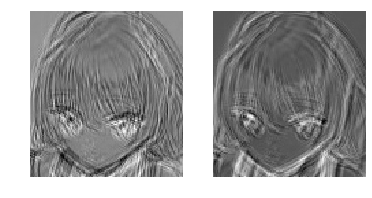

In [14]:
# フィルタ後の画像
plt.figure()
for index in range(2):
    plt.subplot(1, 2, index + 1)
    plt.axis('off')
    plt.imshow(filtered_img[0][index], cmap=plt.cm.gray, interpolation='nearest')

<html>
	<h3>フィルタの形</h3>
	<p>
		畳み込みに使用されたフィルタの形を表示してみると訳の分からないランダムな模様に見えます。
		畳み込みニューラルネットの学習によってこのランダムなフィルタに少しずつ特徴的な形がでてきます。
	</p>
</html>

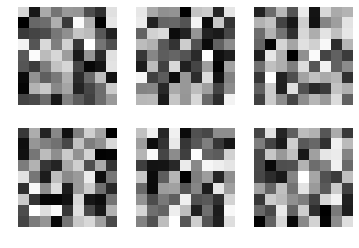

In [15]:
#フィルタの形
w = W.get_value()
plt.figure()
pos = 1
for i in range(2):
    for j in range(3):
        plt.subplot(2, 3, pos)
        plt.axis('off')
        plt.imshow(w[i][j], cmap=plt.cm.gray, interpolation='nearest')
        pos += 1

<html>
	<h3>Max Pooling</h3>
	<p>
		Max Pooling 法とは、あるウィンドウサイズの中で 最大の値を代表値としてサンプリングする方法です。
	</p>
	<p>
		Theanoのtheano.tensor.signal.downsampleパッケージのmax_pool_2dでMax Poolingを提供しています。
	</p>
</html>

In [16]:
# Max Pooling のウィンドウサイズ
maxpool_shape = (2, 2)
# downsampleのパッケージが移動
# pool_out = downsample.max_pool_2d(input, maxpool_shape, ignore_border=True)
pool_out = pool.pool_2d(input, maxpool_shape, ignore_border=True)
f = theano.function([input],pool_out)

In [17]:
# Max Poolingの動作確認
invals = np.random.RandomState(1).rand(3, 2, 5, 5)
print 'invals[0, 0, :, :] =\n', invals[0, 0, :, :]
print 'output[0, 0, :, :] =\n', f(invals)[0, 0, :, :]

invals[0, 0, :, :] =
[[  4.17022005e-01   7.20324493e-01   1.14374817e-04   3.02332573e-01
    1.46755891e-01]
 [  9.23385948e-02   1.86260211e-01   3.45560727e-01   3.96767474e-01
    5.38816734e-01]
 [  4.19194514e-01   6.85219500e-01   2.04452250e-01   8.78117436e-01
    2.73875932e-02]
 [  6.70467510e-01   4.17304802e-01   5.58689828e-01   1.40386939e-01
    1.98101489e-01]
 [  8.00744569e-01   9.68261576e-01   3.13424178e-01   6.92322616e-01
    8.76389152e-01]]
output[0, 0, :, :] =
[[ 0.72032449  0.39676747]
 [ 0.6852195   0.87811744]]


<html>
	<p>
		以下の例では、2x2のマトリックスからその最大の要素（0.7203）が抽出されていることが確認できます。
	</p>	
</html>

In [18]:
print invals[0, 0, 0:2, 0:2]
print invals[0, 0, 0:2, 0:2].max()

[[ 0.417022    0.72032449]
 [ 0.09233859  0.18626021]]
0.720324493442


<html>
	<h3>Max Poolingの結果</h3>
	<p>
		サンプル画像のMax Pooling後の画像を表示してみると、左の画像は瞳の白い部分が強調され、右の部分はまぶたの部分が強調されているように見えます。
	</p>
</html>

In [19]:
# フィルタ後の画像にMax Poolingを施す
pool_img = f(filtered_img)
pool_img.shape

(1, 2, 61, 56)

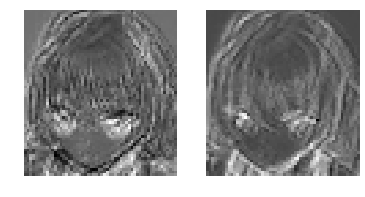

In [20]:
# Max Pooling後の画像
for index in range(2):
    plt.subplot(1, 2, index + 1)
    plt.axis('off')
    plt.imshow(pool_img[0][index], cmap=plt.cm.gray, interpolation='nearest')

<html>
	<h3>LeNetモデル</h3>
	<p>
		LeNetに関する
		<a href="http://sinhrks.hatenablog.com/entry/2014/12/07/203048">Theano で Deep Learning ＜3＞ : 畳み込みニューラルネットワーク</a>
		の説明（図を引用）も分かりやすいです。
	</p>
	<p>
		<img width="60%" height="60%" src="http://cdn-ak.f.st-hatena.com/images/fotolife/s/sinhrks/20141214/20141214220532.png"/>
	</p>
	<p>
		特徴マップに畳み込みを実行し、Max Poolingで疎な結合とし、これを複数層連結して最後に、多層パーセプトロンと目的の活性化関数を施す、
		一連の流れが、とても分かりやすいです。
	</p>
	<p>
		LeNetというのは、畳み込みニューラルネットを発明したLeCunの最初のニューラルネットの名前に由来するのだそうです。
	</p>
</html>

<html>
	<h3>LeNetConvPoolLayerクラス</h3>
	<p>
		Deep Learning TutorialのLeNetConvPoolLayerクラスは、畳み込み層とプーリング層のペアを実装しています。
	</p>
	<p>
		重みWの初期値に、$[ - \sqrt{\frac{6}{in + out}},\sqrt{\frac{6}{in + out}}]$を与えるのは、 
		<a href="http://aidiary.hatenablog.com/entry/20150618/1434628272">Theanoによる多層パーセプトロンの実装</a>
		で紹介されている、活性化関数にtanhを使う時の収束の良いWの初期値です。
	</p>
</html>

In [21]:
class LeNetConvPoolLayer(object):
    """畳み込みニューラルネットの畳み込み層＋プーリング層"""
    def __init__(self, rng, input, image_shape, filter_shape, poolsize=(2, 2)):
        # 入力の特徴マップ数は一致する必要がある
        assert image_shape[1] == filter_shape[1]

        fan_in = np.prod(filter_shape[1:])
        fan_out = filter_shape[0] * np.prod(filter_shape[2:]) / np.prod(poolsize)

        W_bound = np.sqrt(6.0 / (fan_in + fan_out))
        self.W = theano.shared(
            np.asarray(rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                       dtype=theano.config.floatX),  # @UndefinedVariable
            borrow=True)

        b_values = np.zeros((filter_shape[0],), dtype=theano.config.floatX)  # @UndefinedVariable
        self.b = theano.shared(value=b_values, borrow=T)

        # 入力の特徴マップとフィルタの畳み込み
        conv_out = conv.conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape)

        # Max-poolingを用いて各特徴マップをダウンサンプリング
        pooled_out = pool.pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True)

        # バイアスを加える
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        self.params = [self.W, self.b]

<html>
	<h2>畳み込みニューラルネットワークを使った数字認識</h2>
	<p>
		２つのLeNetConvPoolLayerと全結合したHiddenLayerとLogisticRegressionを組み合わせて、
		MNISTの数字文字認識のMini版を試してみます。
	</p>
	<p>
		<a href="http://aidiary.hatenablog.com/entry/20150626/1435329581">Theanoによる畳み込みニューラルネットワークの実装 (1)</a>
		との違いは、最後に収束したモデルを以下の様に保存しているところです。
		<pre>
    # dump layers
    with gzip.open('data/model.pkl.gz', 'wb') as f:
        pickle.dump([layer0_input, layer0, layer1, layer2_input, layer2, layer3], f)			
		</pre>
	</p>
</html>

In [24]:
def evaluate_lenet5(learning_rate=0.1, n_epochs=200,
                    dataset='mnist.pkl.gz', batch_size=500):
    rng = np.random.RandomState(23455)

    # 学習データのロード
    datasets = load_data(dataset)
    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # ミニバッチの数
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] / batch_size

    print "building the model ..."

    # ミニバッチのインデックスを表すシンボル
    index = T.lscalar()

    # ミニバッチの学習データとラベルを表すシンボル
    x = T.matrix('x')
    y = T.ivector('y')

    # 入力
    # 入力のサイズを4Dテンソルに変換
    # batch_sizeは訓練画像の枚数
    # チャンネル数は1
    # (28, 28)はMNISTの画像サイズ
    layer0_input = x.reshape((batch_size, 1, 28, 28))

    # 最初の畳み込み層+プーリング層
    # 畳み込みに使用するフィルタサイズは5x5ピクセル
    # 畳み込みによって画像サイズは28x28ピクセルから24x24ピクセルに落ちる
    # プーリングによって画像サイズはさらに12x12ピクセルに落ちる
    # 特徴マップ数は20枚でそれぞれの特徴マップのサイズは12x12ピクセル
    # 最終的にこの層の出力のサイズは (batch_size, 20, 12, 12) になる
    layer0 = LeNetConvPoolLayer(rng,
                input=layer0_input,
                image_shape=(batch_size, 1, 28, 28),  # 入力画像のサイズを4Dテンソルで指定
                filter_shape=(20, 1, 5, 5),           # フィルタのサイズを4Dテンソルで指定
                poolsize=(2, 2))

    # layer0の出力がlayer1への入力となる
    # layer0の出力画像のサイズは (batch_size, 20, 12, 12)
    # 12x12ピクセルの画像が特徴マップ数分（20枚）ある
    # 畳み込みによって画像サイズは12x12ピクセルから8x8ピクセルに落ちる
    # プーリングによって画像サイズはさらに4x4ピクセルに落ちる
    # 特徴マップ数は50枚でそれぞれの特徴マップのサイズは4x4ピクセル
    # 最終的にこの層の出力のサイズは (batch_size, 50, 4, 4) になる
    layer1 = LeNetConvPoolLayer(rng,
                input=layer0.output,
                image_shape=(batch_size, 20, 12, 12), # 入力画像のサイズを4Dテンソルで指定
                filter_shape=(50, 20, 5, 5),          # フィルタのサイズを4Dテンソルで指定
                poolsize=(2, 2))

    # 隠れ層への入力
    # 画像のピクセルをフラット化する
    # layer1の出力のサイズは (batch_size, 50, 4, 4) なのでflatten()によって
    # (batch_size, 50*4*4) = (batch_size, 800) になる
    layer2_input = layer1.output.flatten(2)

    # 全結合された隠れ層
    # 入力が800ユニット、出力が500ユニット
    layer2 = HiddenLayer(rng,
        input=layer2_input,
        n_in=50 * 4 * 4,
        n_out=500,
        activation=T.tanh)

    # 最終的な数字分類を行うsoftmax層
    layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

    # コスト関数を計算するシンボル
    cost = layer3.negative_log_likelihood(y)

    # index番目のテスト用ミニバッチを入力してエラー率を返す関数を定義
    test_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        })

    # index番目のバリデーション用ミニバッチを入力してエラー率を返す関数を定義
    validate_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        })

    # パラメータ
    params = layer3.params + layer2.params + layer1.params + layer0.params

    # コスト関数の微分
    grads = T.grad(cost, params)

    # パラメータ更新式
    updates = [(param_i, param_i - learning_rate * grad_i) for param_i, grad_i in zip(params, grads)]

    # index番目の訓練バッチを入力し、パラメータを更新する関数を定義
    train_model = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        })

    print "train model ..."

    # eary-stoppingのパラメータ
    patience = 10000
    patience_increase = 2
    improvement_threshold = 0.995
    validation_frequency = min(n_train_batches, patience / 2)

    best_validation_loss = np.inf
    best_iter = 0
    test_score = 0
    start_time = time.clock()

    epoch = 0
    done_looping = False

    fp1 = open("validation_error.txt", "w")
    fp2 = open("test_error.txt", "w")

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in xrange(n_train_batches):
            iter = (epoch - 1) * n_train_batches + minibatch_index
            cost_ij = train_model(minibatch_index)

            if (iter + 1) % validation_frequency == 0:
                validation_losses = [validate_model(i) for i in xrange(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)
                print "epoch %i, minibatch %i/%i, validation error %f %%" % (epoch, minibatch_index + 1, n_train_batches, this_validation_loss * 100)
                fp1.write("%d\t%f\n" % (epoch, this_validation_loss * 100))

                if this_validation_loss < best_validation_loss:
                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        # 十分改善したならまだ改善の余地があるためpatienceを上げてより多くループを回せるようにする
                        patience = max(patience, iter * patience_increase)
                        print "*** iter %d / patience %d" % (iter, patience)
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # テストデータのエラー率も計算
                    test_losses = [test_model(i) for i in xrange(n_test_batches)]
                    test_score = np.mean(test_losses)
                    print "    epoch %i, minibatch %i/%i, test error of best model %f %%" % (epoch, minibatch_index + 1, n_train_batches, test_score * 100)
                    fp2.write("%d\t%f\n" % (epoch, test_score * 100))

            # patienceを超えたらループを終了
            if patience <= iter:
                done_looping = True
                break

    fp1.close()
    fp2.close()

    end_time = time.clock()
    print "Optimization complete."
    print "Best validation score of %f %% obtained at iteration %i, with test performance %f %%" % (best_validation_loss * 100.0, best_iter + 1, test_score * 100.0)
    print "Ran for %.2fm" % ((end_time - start_time) / 60.0)

    # dump layers
    with gzip.open('data/model.pkl.gz', 'wb') as f:
        pickle.dump([layer0_input, layer0, layer1, layer2_input, layer2, layer3], f)

<html>
	<h3>CNNの計算</h3>
	<p>
		さくらのVPSでこの計算をすると約2時間CPUを占有してしまいますので、以下の処理は実行しないでください。
	</p>
	<p>
		または、このノートブックをダウンロードして、ローカルのSageで試してみてください。
	</p>
</html>

In [25]:
# 以下を実行するとCNNを計算します。1/10のmini_mnist.pkl.gzデータで約2時間かかりました。
# さくらのVPSではこの計算を解放できないので、計算結果で読みすすめてください。
evaluate_lenet5(dataset="data/mini_mnist.pkl.gz")

... loading data
building the model ...
train model ...
epoch 1, minibatch 10/10, validation error 37.200000 %
*** iter 9 / patience 10000
    epoch 1, minibatch 10/10, test error of best model 40.400000 %
epoch 2, minibatch 10/10, validation error 34.200000 %
*** iter 19 / patience 10000
    epoch 2, minibatch 10/10, test error of best model 34.400000 %
epoch 3, minibatch 10/10, validation error 22.400000 %
*** iter 29 / patience 10000
    epoch 3, minibatch 10/10, test error of best model 22.400000 %
epoch 4, minibatch 10/10, validation error 18.400000 %
*** iter 39 / patience 10000
    epoch 4, minibatch 10/10, test error of best model 17.200000 %
epoch 5, minibatch 10/10, validation error 16.800000 %
*** iter 49 / patience 10000
    epoch 5, minibatch 10/10, test error of best model 15.000000 %
epoch 6, minibatch 10/10, validation error 16.000000 %
*** iter 59 / patience 10000
    epoch 6, minibatch 10/10, test error of best model 13.800000 %
epoch 7, minibatch 10/10, validation er

<html>
	<h3>フィルタの可視化</h3>
	<p>
		<a href="http://aidiary.hatenablog.com/entry/20150626/1435329581">Theanoによる畳み込みニューラルネットワークの実装 (1)</a>
		のフィルタの可視化を使って最初のフィルタを可視化してみました。		
	</p>
	<p>
		当たり前かもしれませんが、
		<a href="http://aidiary.hatenablog.com/entry/20150626/1435329581">Theanoによる畳み込みニューラルネットワークの実装 (1)</a>
		と同じ結果が得られました。
	</p>
	<p>
		各フィルタの形を見ると数字を特徴付ける形の断片のようにも思われますが、ややシャープさに欠けるように思います。
	</p>
</html>

In [29]:
def visualize_filter(layer):
    """引数に指定されたLeNetConvPoolLayerのフィルタを描画する"""
    W = layer.W.get_value()
    n_filters, n_channels, h, w = W.shape
    plt.figure()
    pos = 1
    for f in range(n_filters):
        for c in range(n_channels):
            plt.subplot(n_channels, n_filters, pos)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.imshow(W[f, c], cmap=plt.cm.gray_r)
            plt.axis('off')
            pos += 1

In [27]:
# 保存したモデルのロード
classifiers = pickle.load(gzip.open("data/model.pkl.gz"))
(layer0_input, layer0, layer1, layer2_input, layer2, layer3) = classifiers

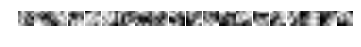

In [30]:
# 最初の畳み込み層のフィルタの可視化
# layer0のフィルタの可視化
visualize_filter(layer0)

<html>
	<h2>テストデータの予測</h2>
	<p>
		畳み込みニューラルネットの練習用データから求まったモデルを使って、
		テスト用データを予測してみましょう。
	</p>
	<p>
		mini_mnist.pkl.gzからテスト用の画像データを読み込み、batch_sizeはCNNの計算と同じ500として、
		モデルの入力layer0_inputとLogisticRegressionの０〜９の数字に対する確率p_y_given_xを返す
		関数predict_modelを定義し、テストデータの最初の500サンプルに対して結果を求めます。
		<pre>
predict_model = theano.function(
    [layer0_input],
    layer3.p_y_given_x,
)			
		</pre>
	</p>
</html>

In [31]:
# テストデータの読み込み
f = gzip.open("data/mini_mnist.pkl.gz", 'rb')
(_, _, test_set) = pickle.load(f)
f.close() 
test_set_x = test_set[0]

In [32]:
# テストデータを使って求まったモデルの認識率を試す
# 分析に使ったのと同じbatch_sizeで計算する必要がある
batch_size = 500
# compile a predictor function
index = T.lscalar()

predict_model = theano.function(
    [layer0_input],
    layer3.p_y_given_x,
)

predicted_values = predict_model(
  test_set_x[:batch_size].reshape((batch_size, 1, 28, 28))
)

<html>
	<p>
		ロジスティック回帰の結果は、
		<pre>
['(7, 0.988)', '(2, 0.733)', '(1, 0.951)', '(0, 0.995)', '(4, 0.936)',
'(1, 0.979)', '(4, 0.957)', '(9, 0.912)', '(6, 0.912)', '(9, 0.844)',
'(0, 0.904)', '(6, 0.668)', '(9, 0.917)', '(0, 0.983)', '(1, 0.991)',
'(5, 0.832)', '(9, 0.790)', '(7, 0.986)', '(3, 0.659)', '(4, 0.979)',
'(9, 0.775)', '(6, 0.952)', '(6, 0.801)', '(5, 0.955)', '(4, 0.862)']			
		</pre>
		多層回帰の結果は、
		<pre>
['(7, 0.999)', '(2, 0.780)', '(1, 0.991)', '(0, 0.999)', '(4, 0.993)',
'(1, 0.998)', '(4, 0.995)', '(9, 0.999)', '(6, 0.995)', '(9, 0.982)',
'(0, 0.996)', '(6, 0.994)', '(9, 0.996)', '(0, 0.993)', '(1, 1.000)',
'(5, 0.974)', '(9, 0.995)', '(7, 0.998)', '(3, 0.980)', '(4, 1.000)',
'(9, 0.911)', '(6, 0.905)', '(6, 0.933)', '(5, 1.000)', '(4, 0.994)']			
		</pre>
		であることから、CNNではかなり認識率が良くなっているように思えます。
	</p>
</html>

In [33]:
print('予測計算終了')
print(["(%d, %.3f)" % (np.argmax(vals), max(vals)) for vals in predicted_values[0:25]])

予測計算終了
['(7, 1.000)', '(2, 0.999)', '(1, 1.000)', '(0, 0.998)', '(4, 1.000)', '(1, 1.000)', '(4, 1.000)', '(9, 0.999)', '(5, 0.985)', '(9, 0.995)', '(0, 1.000)', '(6, 1.000)', '(9, 1.000)', '(0, 1.000)', '(1, 1.000)', '(5, 0.997)', '(9, 0.999)', '(7, 1.000)', '(3, 0.976)', '(4, 1.000)', '(9, 0.995)', '(6, 0.992)', '(6, 0.999)', '(5, 1.000)', '(4, 1.000)']


<html>
	<p>
		同様にlayer0の出力画像も求めることができます。
	</p>
</html>

In [34]:
# テストデータのlayer0の出力画像を計算する
filter0_model =  theano.function(
    [layer0_input],
    layer0.output,
)

filter0_images = filter0_model(
  test_set_x[:batch_size].reshape((batch_size, 1, 28, 28))
)

<html>
	<p>
		テストデータの最初の7をフィルタリングした結果は、以下の様になりました。
	</p>
</html>

(500, 20, 12, 12)


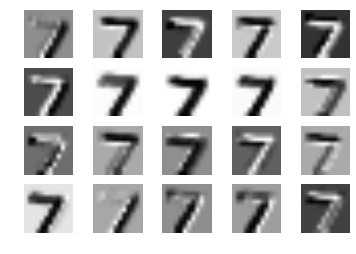

In [35]:
# LeNetConvPoolLayerの出力画像を可視化
# layer0
print filter0_images.shape
plt.figure()
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(filter0_images[0, i], cmap=plt.cm.gray_r)